In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import glob

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
recs = pd.read_csv(r'C:/Users/Roan/Documents/bachelor_scriptie/Machine Learning/predicted.csv').drop("Unnamed: 0", axis = 1)

In [3]:
recs = recs[["user", "vids_watched", "vid", "conspiracy_pred", "strategy"]]
recs.head()

,user,vids_watched,vid,conspiracy_pred,strategy
0,scriptiebot1@gmail.com,1,Jjge2pYKuUM,False,strategy 1
1,scriptiebot1@gmail.com,1,5yx6BWlEVcY,False,strategy 1
2,scriptiebot1@gmail.com,1,Bj9PLkKNF-c,False,strategy 1
3,scriptiebot1@gmail.com,1,SMNHZR1u6KQ,False,strategy 1
4,scriptiebot1@gmail.com,1,46siYNcHMxM,False,strategy 1


In [4]:
strats = recs[["user", "strategy"]].drop_duplicates()

In [5]:
path = r'C:/Users/Roan/Documents/bachelor_scriptie/Results/experiment 1'

all_files = glob.glob(path + "/strat_*/watched*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df)

watched = pd.concat(li, axis=0, ignore_index=True)

In [6]:
watched = pd.merge(watched, strats, left_on="user", right_on="user")

In [7]:
graphs = {"strategy 1" : nx.DiGraph(), "strategy 2" : nx.DiGraph(), 
          "strategy 3" : nx.DiGraph(), "strategy 4" : nx.DiGraph()}

for strat in graphs:
    for i in watched.query("strategy == @strat").itertuples():
        # User, vid number, url
        u, n, url = i[1:4]
        url = url.split("?v=")[1].split("&t=")[0]
        
        # Find recommendations from current video
        p = recs.query("(user == @u) & (vids_watched == @n)")

        # Set seed node
        graphs[strat].add_node(url, vid_type = 2)
        
        # Add recommendations and their types
        graphs[strat].add_nodes_from([x[3].split("&t=")[0] for x in p.itertuples() if x[-2]], vid_type = 3)
        graphs[strat].add_nodes_from([x[3].split("&t=")[0] for x in p.itertuples() if not x[-2]], vid_type = 1)
            
        # Add edges
        graphs[strat].add_edges_from([(url, x[3].split("&t=")[0]) for x in p.itertuples()])

In [8]:
colors = defaultdict(list)

# Determine colors of nodes
for strat in graphs:
    for n in graphs[strat]:
        vid_type = graphs[strat].nodes[n]["vid_type"]
        if vid_type == 2: # seed
            colors[strat].append("#3be016")
        elif vid_type == 1: # regular
            colors[strat].append("#4287f5")
        else: # conspiracy
            colors[strat].append("#f54242")            

In [9]:
def curver(graphs, strat):
    pos = {}
    new = []
    x = []
    
    if strat != "strategy 1":
        smoothing = 0.00000005
    else:
        smoothing = 0.0000000085

    for k, v in nx.multipartite_layout(graphs[strat], subset_key = "vid_type").items():
        x.append(v[0])

    dist = Counter(x)
    seeds = set(x)
    left, seed, right = sorted(list(seeds))

    for k, v in dist.items():
        if k != seed:
            if k == left:
                for i in range(v):
                    new.append(k + (abs(v//2 - i))**2 * smoothing)
            elif k == right:
                for i in range(v):
                    new.append(k - (abs(v//2 - i))**2 * smoothing)
        else:
            new.extend([k] * v)

    for i, dic in enumerate(nx.multipartite_layout(graphs[strat], subset_key = "vid_type").items()):
        pos[dic[0]] = np.array([new[i], dic[1][1]])

    return pos

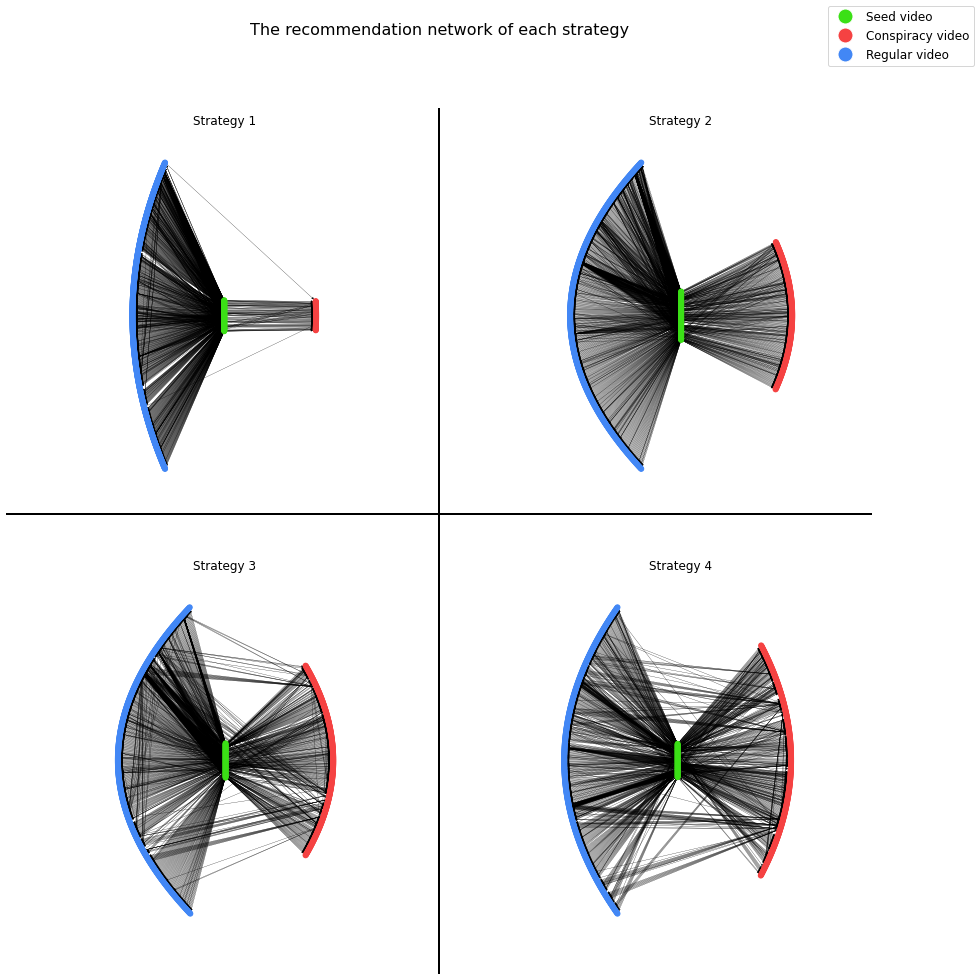

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = axes.flatten()

# Plot the different graphs (this may take a while)
for i, strat in enumerate(colors.keys()):
    nx.draw(graphs[strat], 
            pos = curver(graphs, strat),
            node_color = colors[strat], 
            ax = ax[i],
            node_size = 25,
            width = 0.25,
            arrowsize = 5) 
    
    ax[i].set_title(strat.capitalize())
       
# Dividers between plots
ax[3].plot([0.5, 0.5], [0.1, 0.9], color='black', lw=2,
         transform=plt.gcf().transFigure, clip_on=False);
ax[3].plot([0.1, 0.9], [0.525, 0.525], color='black', lw=2,
         transform=plt.gcf().transFigure, clip_on=False);

# Title and legend
fig.suptitle('The recommendation network of each strategy', fontsize = 16);
legend_elements = [Line2D([0], [0], marker = 'o', color = 'w', label = 'Seed video',
                          markerfacecolor='#3be016', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Conspiracy video',
                          markerfacecolor='#f54242', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Regular video',
                          markerfacecolor='#4287f5', markersize=15)]

fig.legend(handles=legend_elements, fontsize=12);
plt.savefig('recommendation_networks.pdf');

In [10]:
metrics = defaultdict(list)

# Find metrics for each network
for strat in graphs:
    metrics["betweenness_centrality"].append(np.mean(list(nx.betweenness_centrality(graphs[strat]).values())))
    metrics["clustering_coefficient"].append(nx.average_clustering(graphs[strat]))
    
    metrics["density"].append(nx.density(graphs[strat]))
    metrics["size"].append(graphs[strat].size())
    
    metrics["SCC"].append(len(max(list(nx.strongly_connected_components(graphs[strat])), key=len)))
    
    try:
        metrics["avg path length"].append(nx.average_shortest_path_length(graphs[strat].to_undirected()))
    except:
        metrics["avg path length"].append(np.nan)
        
    try:
        metrics["diameter"].append(nx.diameter(graphs[strat].to_undirected()))
    except Exception as e:
        metrics["diameter"].append(np.nan)
    
metrics = pd.DataFrame(metrics, index=graphs.keys())

In [11]:
metrics

,betweenness_centrality,clustering_coefficient,density,size,SCC,avg path length,diameter
strategy 1,1.597418e-07,0.001592,0.002049,1420,1,NaN,NaN
strategy 2,0.000000e+00,0.000000,0.002432,1440,1,NaN,NaN
strategy 3,2.198488e-06,0.009512,0.002101,1428,4,3.906119,6.0
strategy 4,1.136934e-04,0.039018,0.002237,1387,15,4.361461,8.0


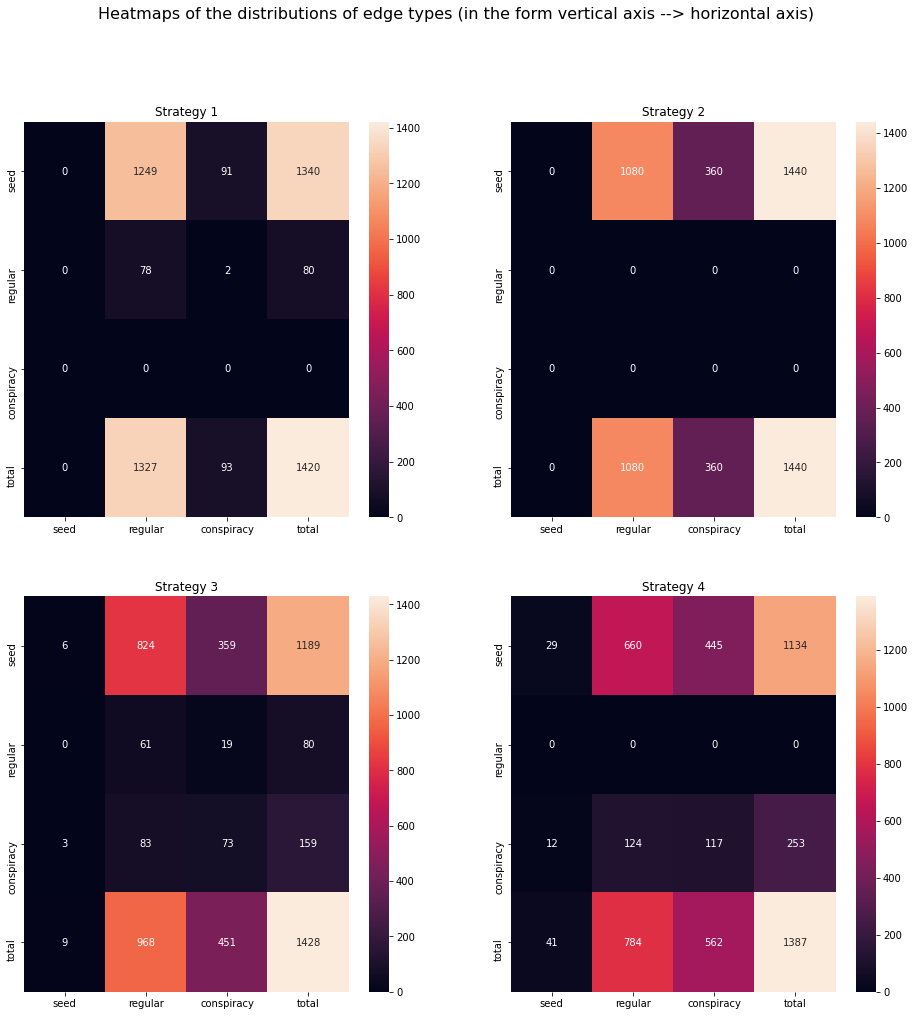

In [68]:
vid_types = {1 : "regular", 2 : "seed", 3 : "conspiracy"}
counts = defaultdict(lambda: defaultdict(int))

heatmaps = []

for strat in graphs:
    for edge in graphs[strat].edges():
        # Find vid type of both nodes of the edge
        A = graphs[strat].nodes[edge[0]]["vid_type"]
        B = graphs[strat].nodes[edge[1]]["vid_type"]
        
        # Convert the number to a string
        A = vid_types[A]
        B = vid_types[B]
        
        # Increase the count of the current strat
        counts[strat][(A, B)] += 1
    
    # Layout of the DataFrame
    mat = pd.DataFrame(index = ["seed", "regular", "conspiracy"], columns = ["seed", "regular", "conspiracy"])
    
    # Add distribution of connection types
    for k, v in counts[strat].items():
        mat.loc[k[0]][k[1]] = v
        
    # Calculate totals
    mat["total"] = mat.sum(axis = 1)
    mat.loc["total"] = mat.sum()
        
    # Fill na with zeroes and convert to integers
    heatmaps.append(mat.fillna(0).astype(int))
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16));
    
for i in range(len(heatmaps)):
    sns.heatmap(heatmaps[i], annot=True, ax=axes.flat[i], fmt='g');
    axes.flat[i].set_title(f"Strategy {i + 1}")

    
fig.suptitle('Heatmaps of the distributions of edge types (in the form vertical axis --> horizontal axis)', fontsize = 16);